<h1> ______________________________________ </h1>

<h1> Full NEXT100 with fiber panels and Kr38m decays simulation analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we analyse the results from the 10000 MC Kr38m decay events simulated in a "realistic" fiber barrel to check if we're able to see the krypton signal with enough resolution. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100 events. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

<h1> _________________________________________________________________________________________________________ </h1>


<h1> __________________________ </h1>
<h2> Functions </h2>

-  <p style="font-size: 17px; color: black;"> <b> gauss(x, a,  mu, sigma): </b> Gaussian normalized to $a$. </p>


-  <p style="font-size: 17px; color: black;"> <b> gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1): </b> Sum of 2 gaussians. </p>


-  <p style="font-size: 17px; color: black;"> <b> dirac(x, x0): </b> Dirac delta at $x0$. </p>




In [2]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    
    return (a/gaussian.sum())*gaussian

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

def dirac(x, x0):
    return np.where((x - x0) == 0, 1, 0)

def EL_yield(E, p, d):
    # E[kV/cm] electric field 
    # p[bar] pressure
    # d[cm] average absorption depth
    return (140*E/p - 116)*d*p # [photons/e⁻]


In [3]:
def dark_rate(dark25, dT, T):
    
#     dark25[Kcps] Dark rate at 25ºC
#     dT[ºC] Decay constant at which dark rate halves
#     T[ºC] Temperature

    exponent = (T - 25)/dT

    dark_rate = dark25*(2**exponent)
    
    return dark_rate

In [4]:
def noise(dark_rate, x_talk, t0, tf, dt, n_sensors):
    
#     dark_rate[Kcps] Number of dark pulses per second
#     x_talk[%] Cross talk probability (so the dark pulse is 2pe instead of 1pe)
#     t0[s] Measurements STARTING time
#     tf[s] Measurements ENDIND time
#     dt[s] Width of the time bin

    """
    Here we do it explained with all the steps, it can be done easier tho

    n_bin = (tf - t0)/dt

    pulse_rate = dark_rate*1e3*dt # probability of having a dark pulse in a bin
    
    pe1 = (1 - x_talk/100) # probability of that pulse being 1pe signal
    pe2 = x_talk/100 # probability of that pulse being 2pe signal

    n_1pe = int(pulse_rate*pe1*n_bin) # number of 1pe dark counts throughout measurement time in 1 sensor
    n_2pe = int(pulse_rate*pe2*n_bin) # number of 2pe dark counts throughout measurement time in 1 sensor
    
    """;
    
    pe1 = (1 - x_talk/100) # probability of that pulse being 1pe signal
    pe2 = x_talk/100 # probability of that pulse being 2pe signal
        
    n_1pe = dark_rate*1e3*(tf - t0)*pe1 # number of 1pe dark counts throughout measurement time in 1 sensor for 1 event
    n_2pe = dark_rate*1e3*(tf - t0)*pe2 # number of 2pe dark counts throughout measurement time in 1 sensor for 1 event
    
    n_1pe = n_1pe*n_sensors # TOTAL number of 1pe dark counts throughout measurement time for all sensors for 1 event
    n_2pe = n_2pe*n_sensors # TOTAL number of 2pe dark counts throughout measurement time for all sensors for 1 event

    n_1pe = int(n_1pe)
    n_2pe = int(n_2pe)
    
    return n_1pe, n_2pe

<h1> __________________________ </h1>
<h2> Global parameters </h2>

-  <p style="font-size: 17px; color: black;"> <b> Pandas dataset params: </b> Allows to set the max number of columns and rows that are shown in a pandas dataset. </p>

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 20)

-  <p style="font-size: 17px; color: black;"> <b> Plots params: </b> In case you want to fix the parameters for all plots. </p>

In [6]:
# plt.rcParams["figure.figsize"] = 10, 8
# plt.rcParams["font.size"] = 10

-  <p style="font-size: 17px; color: black;"> <b> Analysis parameters </b> </p>

 -  <p style="font-size: 17px; color: black;"> <b> dark_rate: </b> Dark pulses rate. </p>
 -  <p style="font-size: 17px; color: black;"> <b> x_talk: </b> Cross talk probability. </p>
 -  <p style="font-size: 17px; color: black;"> <b> n_sensors: </b> Total number of sensors used. </p>
 

In [7]:
dark25 = 2000 # [Kcps] (1Kcps = 1e3 dark pulses per second) DCR at 25ºC
x_talk = 7 # [%] Probability of a dark count to be 2pe instead of 1pe
n_sensors = 90 
t_binning = 0.1 # [ns] Conversion constant from bin enumerations to nanoseconds (binning used in the simulation)
dT = 5.3 # [ºC] Decay factor at which the dark rate halves

<h1> __________________________ </h1>
<h2> Data </h2>

-  <p style="font-size: 17px; color: black;"> <b> Reading the file </b> </p>

-  <p style="font-size: 17px; color: black;"> File's path </p>

In [8]:
# path = '/home/investigator/mariandbt/python/data/'
# path = path + '/20230921_NEXT100_full_fiber_barrel'

path = '/home/investigator/mariandbt/nexus'

filename = os.path.join(path, "Next100_full.next.h5")
# filename = os.path.join(path, "Next100_full_1event.next.h5")
# filename = os.path.join(path, "Next100_full_noEL_100ev.next.h5")
# filename = os.path.join(path, "Next100_full_noEL_100ev_sensName.next.h5")
# filename = os.path.join(path, "Next100_full_noEL_20ev.next.h5")


-  <p style="font-size: 17px; color: black;"> In a .h5 file there are several objects, so we print them all to then pick the one we're interested in </p>

In [9]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/nexus/Next100_full.next.h5 (File) ''
Last modif.: '2023-10-03T13:49:52+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(46,)) ''
/MC/hits (Table(15,)) ''
/MC/particles (Table(77810,)) ''
/MC/sns_positions (Table(40,)) ''
/MC/sns_response (Table(40,)) ''



-  <p style="font-size: 17px; color: black;"> Read the file and make a copy to work with, this way it's easier to re-start the copy instead of re-reading the file. </p>

In [10]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
# data = pd.read_hdf(filename, "/MC/particles")
# data = pd.read_hdf(filename, "/MC/sns_positions")
data = pd.read_hdf(filename, "/MC/sns_response")
# data = pd.read_hdf(filename, "/MC/hits")
# dst = pd.read_hdf(filename, "/MC/hits").groupby("event_id").get_group(event_id)

In [11]:
dst = data.copy()

In [12]:
dst.time_bin = dst.time_bin*t_binning # change units to ns

In [13]:
# dst.final_volume.unique() 
# dst.initial_volume.unique()
# dst.particle_name.unique()
dst.sensor_id.unique(), len(dst.sensor_id.unique())

(array([18171, 26173, 34170, 32174, 41058, 49031, 22015, 48037, 47011,
        23041, 23026, 13021, 56003, 11019, 22055, 37002, 23019, 42047,
        22031, 39027, 14053, 46062,  7060, 49047, 36060, 16046, 27045,
        23009, 27051, 23007,  7010, 20027, 37004, 43055, 11007, 14062,
        13037, 30036, 14063,  2049], dtype=uint32),
 40)

In [14]:
dst.time_bin.unique(), len(dst.time_bin.unique())
dst.charge.unique(), len(dst.charge.unique())


(array([1], dtype=uint32), 1)

In [15]:
# dst.loc[dst.final_volume.str.contains('SENS')]
# dst.loc[(dst.initial_volume != 'WORLD') & (dst.primary == 0)]
dst

,event_id,sensor_id,time_bin,charge
0,0,18171,593714.7,1
1,0,26173,593353.2,1
2,0,34170,594254.5,1
3,0,32174,596223.7,1
4,0,41058,59.3,1
5,0,49031,59.3,1
6,0,22015,59.3,1
7,0,48037,59.7,1
8,0,47011,59.5,1
9,0,23041,59.4,1


-  <p style="font-size: 17px; color: black;"> <b> Tests on the data: </b> We perform some tests on the dataset to check the simulation is valid. </p>

-  <p style="font-size: 17px; color: black;"> Group the data by sensors. </p>

In [16]:
dst.charge.sum(), len(dst.charge)

(40, 40)

In [17]:
# g = dst.groupby(dst.sensor_id)
g = dst.groupby(dst.event_id)


In [18]:
# g.charge.sum()

<h1> __________________________ </h1>
<h2> Analysis </h2>

In [19]:
dst_sens = pd.read_hdf(filename, "/MC/sns_positions")
dst_sens.sensor_name.unique()
len(dst_sens.loc[dst_sens.sensor_name == 'F_SENSOR'])
# dst_sens.loc[dst_sens.sensor_name == 'F_SENSOR']
dst_sens

,sensor_id,sensor_name,x,y,z
0,18171,F_SENSOR,469.323761,117.278946,7.825000
1,26173,F_SENSOR,-469.323761,117.278946,7.825000
2,34170,F_SENSOR,451.908325,-182.389755,7.825000
3,32174,F_SENSOR,101.145782,-476.714447,7.825000
4,41058,SiPM,241.524994,39.375000,-34.099998
5,49031,SiPM,303.725006,179.324997,-34.099998
6,22015,SiPM,-100.574997,-256.075012,-34.099998
7,48037,SiPM,319.274994,23.825001,-34.099998
8,47011,SiPM,272.625000,-131.675003,-34.099998
9,23041,SiPM,-38.375000,-224.975006,-34.099998


In [20]:
dst_particle = pd.read_hdf(filename, "/MC/particles")

In [21]:
dst_particle[dst_particle.particle_name == 'ie-']

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,initial_volume,final_volume,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
372,0,14,ie-,0,1,-71.935204,-245.827011,585.879761,0.000010,-61.817539,-245.008652,-10.201,593730.6250,ACTIVE,GAS,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,3.525,Clustering,Drift
735,0,13,ie-,0,1,-71.934593,-245.827606,585.879700,0.000031,-60.183098,-247.779327,-10.201,592304.2500,ACTIVE,GAS,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,3.525,Clustering,Drift
1037,0,12,ie-,0,1,-71.934074,-245.828094,585.879639,0.000048,-84.817085,-255.525864,-10.201,594109.7500,ACTIVE,GAS,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,3.525,Clustering,Drift
1385,0,11,ie-,0,1,-71.934959,-245.827255,585.879700,0.000019,-76.772820,-254.667648,-10.201,596859.5000,ACTIVE,GAS,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,3.525,Clustering,Drift
1724,0,10,ie-,0,1,-71.933960,-245.828217,585.879639,0.000052,-76.185028,-244.784012,-10.201,595968.8125,ACTIVE,GAS,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,3.525,Clustering,Drift
2100,0,9,ie-,0,1,-71.934914,-245.827301,585.879700,0.000020,-75.982094,-242.058884,-10.201,590485.0625,ACTIVE,GAS,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,3.525,Clustering,Drift
2498,0,8,ie-,0,1,-71.935463,-245.826767,585.879761,0.000002,-72.814445,-238.244034,-10.201,595692.6875,ACTIVE,GAS,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,3.525,Clustering,Drift
2867,0,7,ie-,0,1,-71.933853,-245.828308,585.879578,0.000055,-75.321449,-235.186920,-10.201,596487.2500,ACTIVE,GAS,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,3.525,Clustering,Drift
3236,0,6,ie-,0,1,-71.935295,-245.826935,585.879761,0.000008,-70.701729,-251.053818,-10.201,595313.7500,ACTIVE,GAS,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,3.525,Clustering,Drift
3601,0,5,ie-,0,1,-71.934845,-245.827362,585.879700,0.000022,-71.020645,-238.490082,-10.201,592492.0625,ACTIVE,GAS,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,3.525,Clustering,Drift


In [22]:
dst_particle = pd.read_hdf(filename, "/MC/particles")
dst_particle.loc[dst_particle.particle_name == 'opticalphoton']
dst_particle.loc[(dst_particle.particle_name == 'opticalphoton') & 
                 (dst_particle.creator_proc == 'Scintillation') 
#                  (dst_particle.final_volume.str.contains('SENSAREA')) 
#                  (dst_particle.final_volume.str.contains('F_SENSOR_SENSAREA')) 
#                  (~dst_particle.final_volume.str.contains('F_SENSOR_CASE_')) 
#                  (dst_particle.event_id < 5) 
                ]

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,initial_volume,final_volume,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,0,23,opticalphoton,0,1,-71.933914,-245.828247,585.879639,59.340721,277.228180,-396.677765,614.104675,60.648109,ACTIVE,Y11_WLS_15127,6.216866e-06,-0.000003,5.025513e-07,5.990598e-06,-0.000003,-1.047304e-06,0.000007,381.400604,Scintillation,OpWLS
1,0,22,opticalphoton,0,1,-71.934349,-245.827835,585.879639,54.080811,-325.735626,356.008057,918.148560,56.616550,ACTIVE,Y11_WLS_664,-2.471402e-06,0.000006,3.235485e-06,-1.499873e-06,0.000006,3.389858e-06,0.000007,732.819336,Scintillation,OpWLS
2,0,21,opticalphoton,0,1,-71.934769,-245.827438,585.879700,55.325741,-282.488983,-392.505890,539.454651,56.232544,ACTIVE,Y11_WLS_1149,-5.857385e-06,-0.000004,-1.291494e-06,-6.878018e-06,-0.000002,-1.583539e-06,0.000007,260.773712,Scintillation,OpWLS
3,0,20,opticalphoton,0,1,-71.933876,-245.828293,585.879578,60.947071,340.899628,-343.235352,1015.071289,63.012661,ACTIVE,Y11_WLS_1544,4.596198e-06,-0.000001,4.778320e-06,5.143063e-06,-0.000003,3.306322e-06,0.000007,603.427856,Scintillation,OpWLS
8,0,19,opticalphoton,0,1,-71.935181,-245.827042,585.879761,78.957596,2.054331,-482.333069,613.999146,79.825417,ACTIVE,Y11_WLS_1382,2.156249e-06,-0.000007,8.194732e-07,2.063848e-06,-0.000007,7.602138e-07,0.000007,249.399796,Scintillation,OpWLS
16,0,18,opticalphoton,0,1,-71.934227,-245.827957,585.879639,4.825433,81.463142,-482.060486,582.755066,5.803234,ACTIVE,Y11_WLS_133,3.929379e-06,-0.000006,-8.003815e-08,3.046130e-06,-0.000006,-1.083937e-06,0.000007,281.684814,Scintillation,OpWLS
25,0,17,opticalphoton,0,1,-71.934402,-245.827789,585.879639,90.921783,9.406222,-482.067993,409.279053,91.977341,ACTIVE,Y11_WLS_1375,1.873538e-06,-0.000005,-4.067681e-06,-7.396100e-07,-0.000006,-2.690229e-06,0.000007,305.963257,Scintillation,OpWLS
26,0,16,opticalphoton,0,1,-71.933762,-245.828400,585.879578,88.192467,-20.987888,-482.449829,509.476898,89.083038,ACTIVE,Y11_WLS_13105,1.487895e-06,-0.000007,-2.231373e-06,4.150271e-06,-0.000006,4.925707e-08,0.000007,253.815994,Scintillation,OpWLS
27,0,15,opticalphoton,0,1,-71.934837,-245.827377,585.879700,83.775536,278.461060,395.843048,224.386414,89.963753,ACTIVE,Y11_WLS_243,1.555123e-06,0.000003,6.926160e-06,3.949231e-07,0.000005,-5.327407e-06,0.000008,1723.351562,Scintillation,OpWLS
4660,0,4678,opticalphoton,0,1,-71.932564,-245.829010,585.879883,52.043953,-189.458115,-444.288818,619.910583,52.889961,ACTIVE,Y11_WLS_12111,-3.889240e-06,-0.000007,1.126164e-06,-4.193338e-06,-0.000005,3.450229e-06,0.000008,233.145111,Scintillation,OpWLS


In [23]:
dst_particle.final_proc.unique()

array(['OpWLS', 'OpAbsorption', 'Transportation', 'Drift', 'NoProcess'],
      dtype=object)

In [24]:
dst_particle.particle_name.unique()
# dst_particle.final_volume.unique()


array(['opticalphoton', 'ie-', 'e-'], dtype=object)

In [25]:
len(dst_particle.loc[(dst_particle.particle_name == 'opticalphoton') &
                     (dst_particle.final_volume.str.contains('SENSAREA'))])
#                      (dst_particle.final_volume.str.contains('F_SENSOR_SENSAREA'))])
# len(dst_particle.loc[(dst_particle.final_volume.str.contains('F_SENSOR'))])


81

In [26]:
dst_particle.loc[(dst_particle.particle_name == 'opticalphoton') &
                                   (dst_particle.final_proc != 'OpWLS')
                                  ]

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,initial_volume,final_volume,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
5,0,26,opticalphoton,0,25,341.219788,-343.331451,1015.251465,72.714645,249.253082,32.389507,-0.087849,118.580696,Y11,EL_GRID_GATE,-1.854590e-06,1.114235e-06,1.618073e-07,2.003372e-06,4.763533e-07,-6.832235e-07,0.000002,13608.339844,OpWLS,OpAbsorption
7,0,27,opticalphoton,0,24,341.314514,-343.261658,1014.791077,72.715309,-241.615204,356.075684,-10.192457,112.538979,Y11,EL_GRID_ANODE,1.419120e-06,2.057339e-06,-3.674919e-07,1.736099e-07,-2.459859e-06,5.482221e-07,0.000003,11809.371094,OpWLS,OpAbsorption
11,0,34,opticalphoton,0,29,-486.274506,20.135000,1011.629944,101.225563,52.919579,33.785145,-0.033521,124.082642,Y11,EL_GRID_GATE,-2.208021e-06,4.114262e-07,7.540185e-07,5.534491e-07,6.288831e-07,-2.216162e-06,0.000002,6756.184570,OpWLS,OpAbsorption
12,0,33,opticalphoton,0,29,-486.274506,20.135000,1011.629944,101.225563,-69.973335,-102.805107,-10.190198,116.942596,Y11,EL_GRID_ANODE,7.791228e-07,2.209788e-06,7.386482e-07,2.375548e-06,-5.257902e-07,3.407542e-07,0.000002,4620.140137,OpWLS,OpAbsorption
13,0,32,opticalphoton,0,29,-486.274506,20.135000,1011.629944,101.225563,-486.210846,19.987709,8.525000,106.827377,Y11,F_SENSOR_CASE_80,-7.063787e-07,2.923772e-07,-2.318841e-06,-5.718092e-07,5.074343e-07,-2.318841e-06,0.000002,1056.215210,OpWLS,Transportation
14,0,31,opticalphoton,0,29,-486.274506,20.135000,1011.629944,101.225563,-79.393845,350.379944,-0.068845,114.505219,Y11,EL_GRID_GATE,-1.894336e-07,-1.381557e-06,-2.106812e-06,-3.786838e-07,8.844615e-07,-2.336144e-06,0.000003,3916.331299,OpWLS,OpAbsorption
18,0,38,opticalphoton,0,36,81.363617,-482.185974,582.687988,15.504131,-383.902618,301.179077,469.782013,18.607771,Y11,TEFLON_PANEL_7,-9.670471e-07,1.155465e-06,-2.187885e-06,-1.990051e-06,1.747713e-06,-2.057149e-07,0.000003,921.204224,OpWLS,Transportation
20,0,41,opticalphoton,0,37,81.706367,-482.381134,582.231567,24.035427,-94.587502,90.608315,-0.021296,59.741249,Y11,EL_GRID_GATE,2.112140e-06,-6.386356e-07,1.153135e-06,-4.401469e-07,-7.736052e-07,-2.325192e-06,0.000002,10557.874023,OpWLS,OpAbsorption
21,0,40,opticalphoton,0,37,81.706367,-482.381134,582.231567,24.035427,-255.136597,401.389130,1185.425049,49.555382,Y11,TEFLON_CAP,3.306804e-07,-1.786845e-06,-1.523647e-06,6.650609e-07,-5.969408e-07,2.196593e-06,0.000002,7519.785645,OpWLS,Transportation
22,0,39,opticalphoton,0,37,81.706367,-482.381134,582.231567,24.035427,81.598640,-482.350006,8.525000,27.079885,Y11,F_SENSOR_CASE_130,-7.026484e-08,2.182997e-08,-2.194669e-06,-6.693775e-08,3.054558e-08,-2.194669e-06,0.000002,574.028870,OpWLS,Transportation


In [27]:
# category_counts = dst_particle.final_volume.value_counts()
category_counts = dst_particle.loc[(dst_particle.particle_name == 'opticalphoton') &
                                   (dst_particle.final_proc != 'OpWLS')
                                  ].final_volume.value_counts()
# category_counts

In [28]:
category_counts[:10]

EL_GRID_ANODE      11243
EL_GRID_GATE       10239
SIPM_BOARD_MASK     1716
LAB                  873
TEFLON_CAP           732
Y11                  692
SIPM_BOARD           641
SIPM_S13372          603
ANODE_RING           580
TP_COPPER_PLATE      481
Name: final_volume, dtype: int64

In [29]:
# dst_particle.loc[dst_particle.final_volume == 'EL_GAP']

In [30]:
# category_counts[category_counts > 10]

In [31]:
# dst_particle.loc[dst_particle.initial_volume.str.contains('Y11_WLS')]
# dst_particle.loc[dst_particle.final_volume == 'Y11']


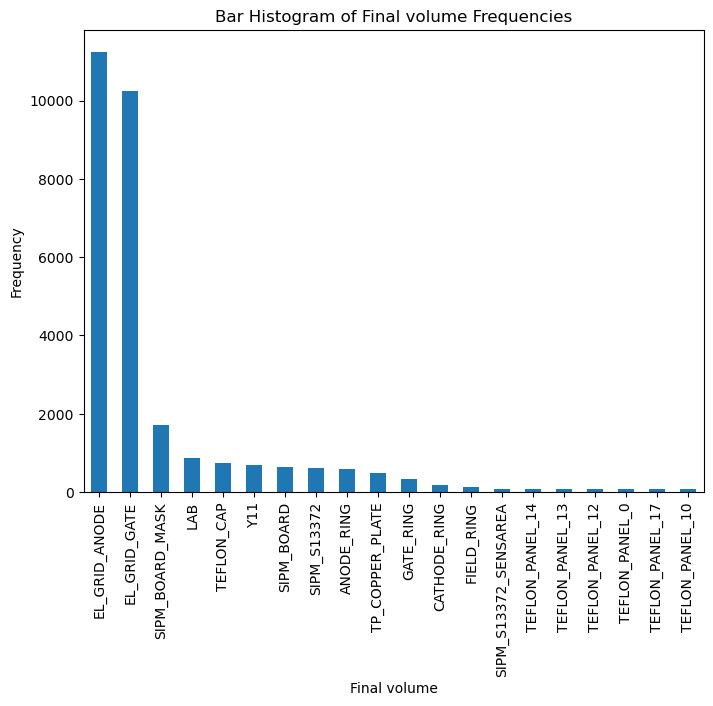

In [32]:
plt.figure(figsize=(8, 6))

# category_counts[category_counts > 100].plot(kind="bar")
category_counts[:20].plot(kind="bar")

plt.xlabel("Final volume")
plt.ylabel("Frequency")
plt.title("Bar Histogram of Final volume Frequencies")
plt.xticks(rotation=90)  # Rotates the x-axis labels if needed
plt.show()


<h2> Charge distribution in an event. </h2>

-  <p style="font-size: 17px; color: black;"> 1 event </p>

In [33]:
ev = 0

In [34]:
wvf = dst.groupby(dst.event_id).get_group(ev)

In [35]:
# wvf.groupby(wvf.sensor_id).get_group(3163)
wvf

,event_id,sensor_id,time_bin,charge
0,0,18171,593714.7,1
1,0,26173,593353.2,1
2,0,34170,594254.5,1
3,0,32174,596223.7,1
4,0,41058,59.3,1
5,0,49031,59.3,1
6,0,22015,59.3,1
7,0,48037,59.7,1
8,0,47011,59.5,1
9,0,23041,59.4,1


-  <p style="font-size: 17px; color: black;"> All events </p>

In [36]:
n_events = dst.event_id.max() + 1

In [37]:
# for ev, ev_group in dst.groupby(dst.event_id):
#     for sens, sens_group in ev_group.groupby(ev_group.sensor_id):
        
#         Introduce here a np.hist() for each sensor in each event and obtain the corresponding info
        
        

In [38]:
# len(time_bin), len(np.unique(time_bin))

In [39]:
# time_bin

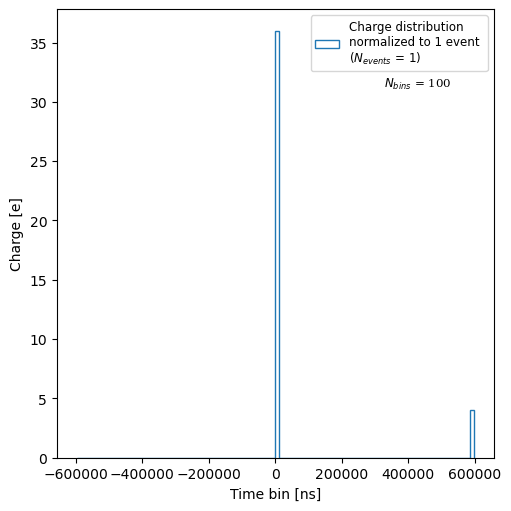

In [55]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

n_bins = 100
font_size = 8.5

events, bins, bars = ax.hist(dst.time_bin, n_bins, 
                             weights = dst.charge/n_events,
                             density=False,
                             range=(-1*(dst.time_bin.max()), dst.time_bin.max()),
                             label='Charge distribution \nnormalized to 1 event \n($N_{events}$ = %s)'%(n_events), 
                             histtype='step')

ax.text(0.75, .85, r'$N_{bins}$ = ' + str(n_bins), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.set_ylabel('Charge [e]')
ax.set_xlabel('Time bin [ns]')
ax.legend(fontsize = font_size);


In [41]:
events.sum()

40.0

<h2> Add dark counts. </h2>

-  <p style="font-size: 17px; color: black;"> Create the noise at 25ºC </p>

In [42]:
dt = 1e-6 # [s] = 1us
dt = 10*1e-6 # [s] = 1us


In [43]:
tf = dst.time_bin.max()*1e-9 # [s]
t0 = -1*tf # [s]
n_bins = (tf - t0)/dt

In [44]:
n_1pe, n_2pe = noise(dark25, x_talk, t0, tf, dt, n_sensors)

print('We have %s 1pe dark pulses and %s 2pe dark pulses'%(n_1pe, n_2pe))

We have 199615 1pe dark pulses and 15024 2pe dark pulses


In [45]:
noise_1pe = np.random.randint(t0*1e9, tf*1e9, n_1pe) # [ns]
noise_2pe = np.random.randint(t0*1e9, tf*1e9, n_2pe) # [ns]

t_noise = np.concatenate((noise_1pe, noise_2pe))
c_noise = np.concatenate((1*np.ones(n_1pe), 2*np.ones(n_2pe)))

In [46]:
t_signal = np.asarray(dst.time_bin)
c_signal = np.asarray(dst.charge)

In [47]:
tt = np.concatenate((t_signal, t_noise))
cc = np.concatenate((c_signal/n_events, c_noise))

Total events = 229703 = 40 (signal) + 229663 (bkg) = 229703


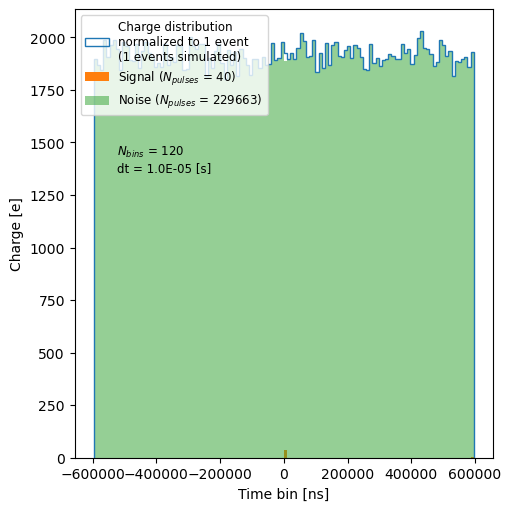

In [48]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

font_size = 8.5


t_low = -1*(tt.max())
t_up = tt.max()

#     dt = (t_up - t_low)*1e-9/n_bins # [s]
n_bins = int((t_up - t_low)*1e-9/dt) + 1

# "Data"
events, bins, bars = ax.hist(tt, n_bins, 
                             weights = cc,  # only part of it has to be normalized (signal part)
                             density=False,
                             range=(t_low, t_up),
                             label='Charge distribution \nnormalized to 1 event \n(%i events simulated)'%(n_events), 
                             histtype='step')


# Signal
s_events, s_bins, s_bars = ax.hist(t_signal, n_bins, 
                                   weights = c_signal/n_events,
                                   density=False,
                                   range=(t_low, t_up),
                                   label='Signal ($N_{pulses}$ = %i)'%((c_signal/n_events).sum()), 
                                   alpha = 1,
                                   histtype='stepfilled')


# Noise
bkg_events, bkg_bins, bkg_bars = ax.hist(t_noise, n_bins, 
                                         weights = c_noise, # noise is already normalized
                                         density=False,
                                         range=(t_low, t_up),
                                         label='Noise ($N_{pulses}$ = %i)'%(c_noise.sum()), 
                                         alpha = 0.5,
                                         histtype='stepfilled')


ax.text(0.1, .7, '$N_{bins}$ = %s \ndt = %.1E [s]'%(n_bins, dt), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))

ax.set_ylabel('Charge [e]')
ax.set_xlabel('Time bin [ns]')
ax.legend(fontsize = font_size, loc = 'upper left');

print('Total events = %i = %i (signal) + %i (bkg) = %i'%(s_events.sum() + bkg_events.sum(), 
                                                         s_events.sum(), bkg_events.sum(), 
                                                         events.sum()))


In [49]:
events.mean()

1914.1916666666666

Total events = 229703 = 40 (signal) + 229663 (bkg) = 229703
Total events = 229703 = 40 (signal) + 229663 (bkg) = 229703
Total events = 229703 = 40 (signal) + 229663 (bkg) = 229703
Total events = 229703 = 40 (signal) + 229663 (bkg) = 229703
Total events = 229703 = 40 (signal) + 229663 (bkg) = 229703
Total events = 229703 = 40 (signal) + 229663 (bkg) = 229703


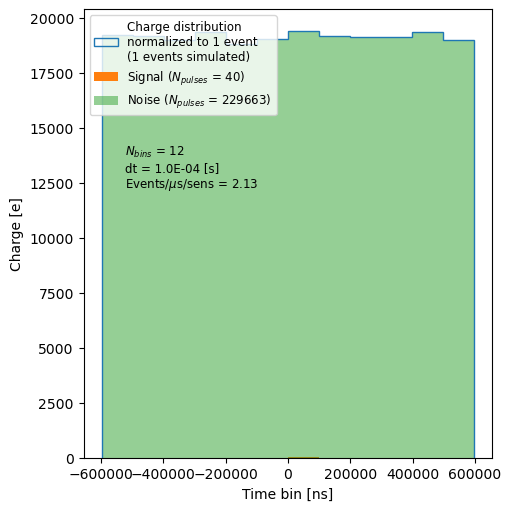

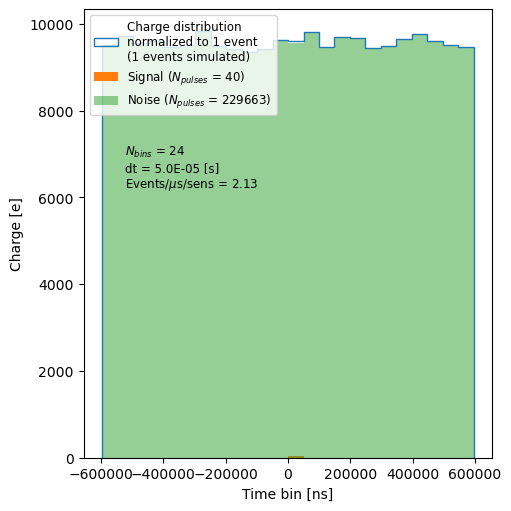

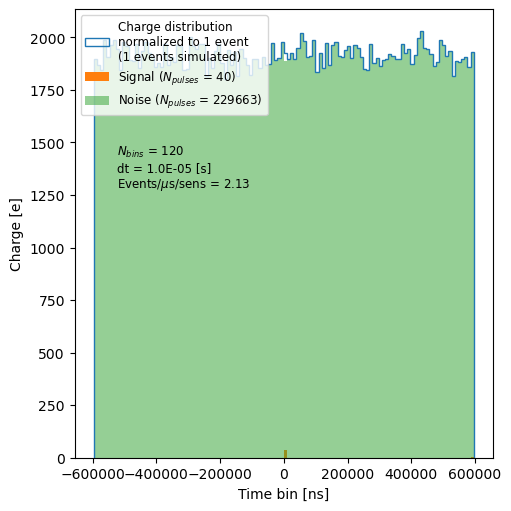

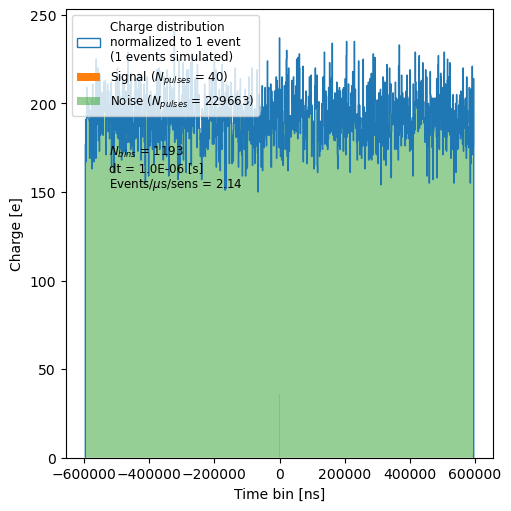

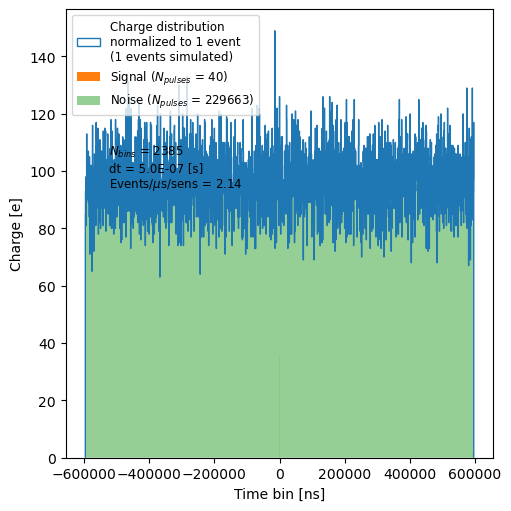

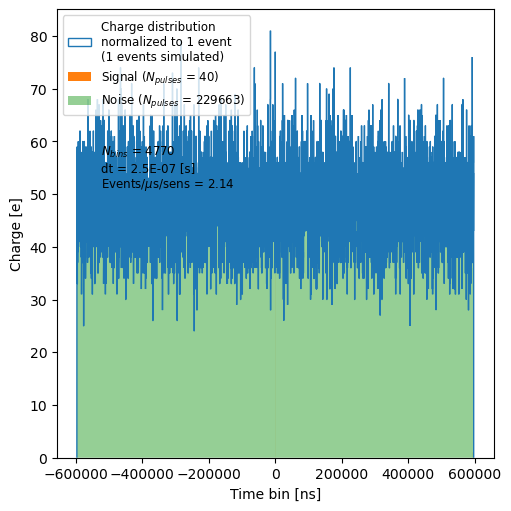

In [50]:
font_size = 8.5

# for n_bins in [200, 150, 100, 70, 50, 20, 10, 5]:
for dt in [1e-4, 5e-5, 1e-5, 1e-6, 0.5e-6, 0.25e-6]:
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

    t_low = -1*(tt.max())
    t_up = tt.max()

#     dt = (t_up - t_low)*1e-9/n_bins # [s]
    n_bins = int((t_up - t_low)*1e-9/dt) + 1

    # "Data"
    events, bins, bars = ax.hist(tt, n_bins, 
                                 weights = cc,  # only part of it has to be normalized (signal part)
                                 density=False,
                                 range=(t_low, t_up),
                                 label='Charge distribution \nnormalized to 1 event \n(%i events simulated)'%(n_events), 
                                 histtype='step')


    # Signal
    s_events, s_bins, s_bars = ax.hist(t_signal, n_bins, 
                                       weights = c_signal/n_events,
                                       density=False,
                                       range=(t_low, t_up),
                                       label='Signal ($N_{pulses}$ = %i)'%((c_signal/n_events).sum()), 
                                       alpha = 1,
                                       histtype='stepfilled')


    # Noise
    bkg_events, bkg_bins, bkg_bars = ax.hist(t_noise, n_bins, 
                                             weights = c_noise, # noise is already normalized
                                             density=False,
                                             range=(t_low, t_up),
                                             label='Noise ($N_{pulses}$ = %i)'%(c_noise.sum()), 
                                             alpha = 0.5,
                                             histtype='stepfilled')


    ax.text(0.1, .7, 
            '$N_{bins}$ = %s \ndt = %.1E [s] \nEvents/$\mu$s/sens = %.2f'%(n_bins, dt, events.mean()*1e-6/dt/n_sensors), 
            transform = ax.transAxes,
            fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
            bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))

    ax.set_ylabel('Charge [e]')
    ax.set_xlabel('Time bin [ns]')
    ax.legend(fontsize = font_size, loc = 'upper left');

    print('Total events = %i = %i (signal) + %i (bkg) = %i'%(s_events.sum() + bkg_events.sum(), 
                                                             s_events.sum(), bkg_events.sum(), 
                                                             events.sum()))
    


-  <p style="font-size: 17px; color: black;"> Create the noise at different ºC </p>

In [51]:
dt = 1e-6 # [s] = 1us

In [52]:
tf = dst.time_bin.max()*1e-9 # [s]
t0 = -1*tf # [s]
n_bins = (tf - t0)/dt

In [53]:
# temp = 20

We have 199615 1pe dark pulses and 15024 2pe dark pulses
Total events = 229703 = 40 (signal) + 229663 (bkg) = 229703
Total events = 229703 = 40 (signal) + 229663 (bkg) = 229703
Total events = 229703 = 40 (signal) + 229663 (bkg) = 229703
Total events = 229703 = 40 (signal) + 229663 (bkg) = 229703
Total events = 229703 = 40 (signal) + 229663 (bkg) = 229703
We have 143945 1pe dark pulses and 10834 2pe dark pulses
Total events = 165653 = 40 (signal) + 165613 (bkg) = 165653
Total events = 165653 = 40 (signal) + 165613 (bkg) = 165653
Total events = 165653 = 40 (signal) + 165613 (bkg) = 165653
Total events = 165653 = 40 (signal) + 165613 (bkg) = 165653
Total events = 165653 = 40 (signal) + 165613 (bkg) = 165653
We have 103801 1pe dark pulses and 7813 2pe dark pulses
Total events = 119467 = 40 (signal) + 119427 (bkg) = 119467
Total events = 119467 = 40 (signal) + 119427 (bkg) = 119467
Total events = 119467 = 40 (signal) + 119427 (bkg) = 119467
Total events = 119467 = 40 (signal) + 119427 (bkg)

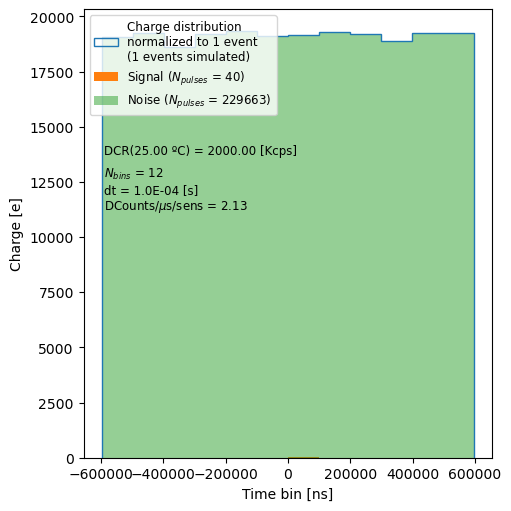

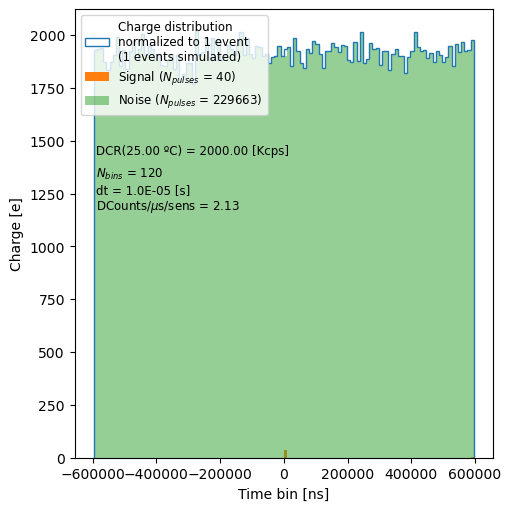

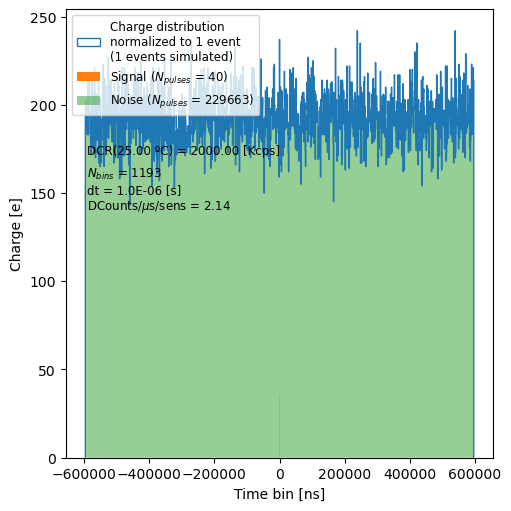

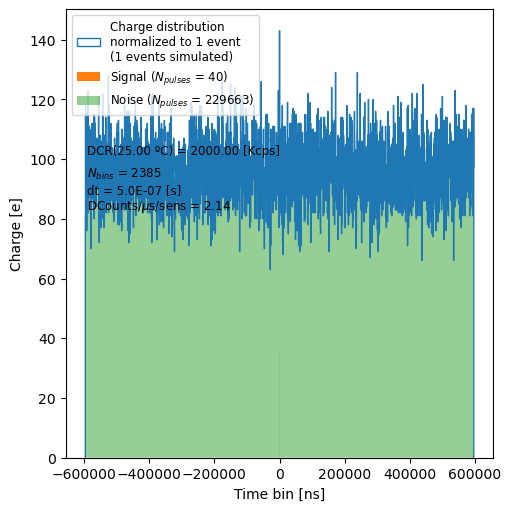

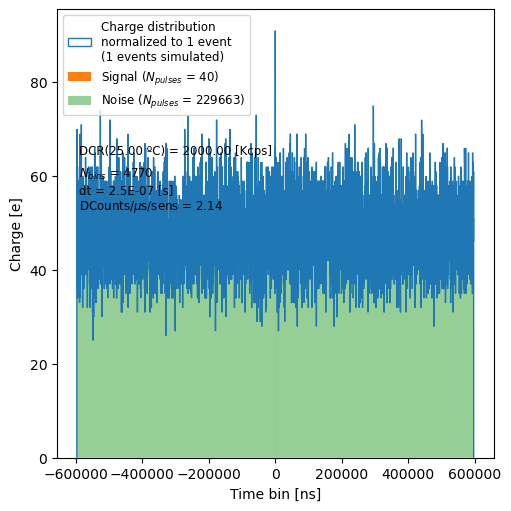

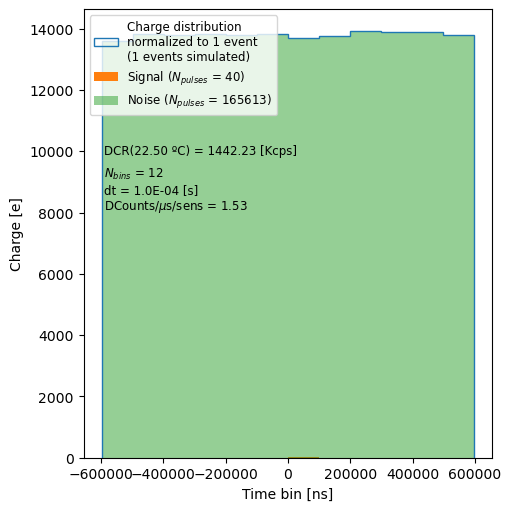

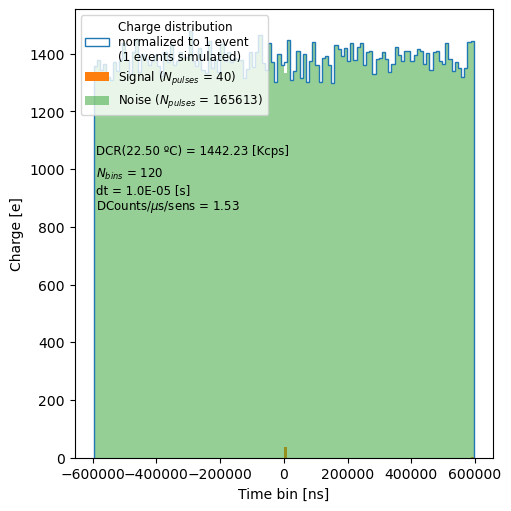

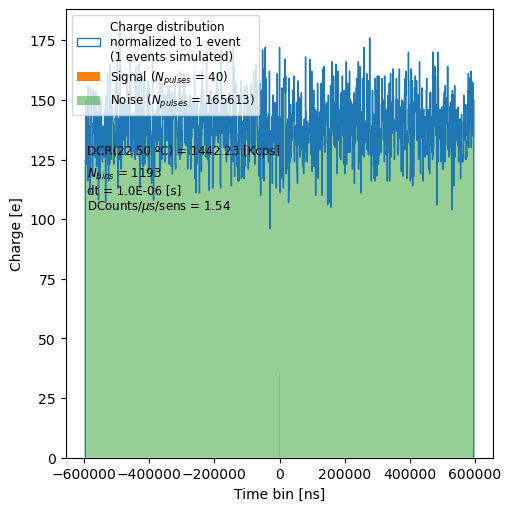

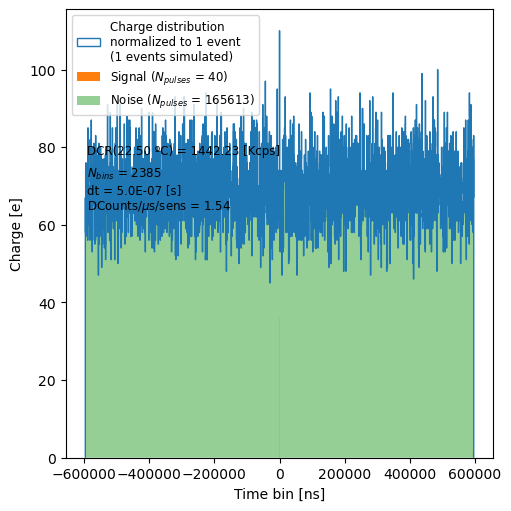

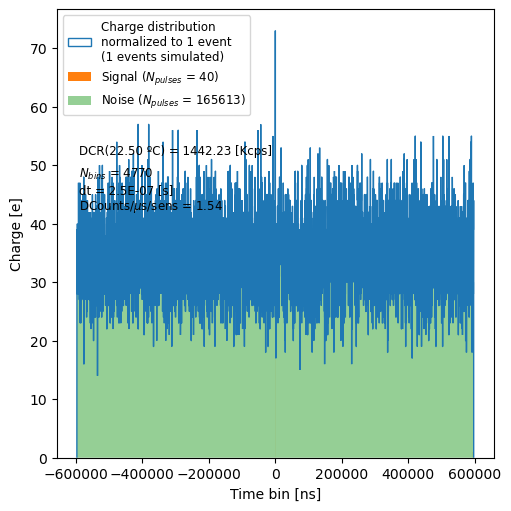

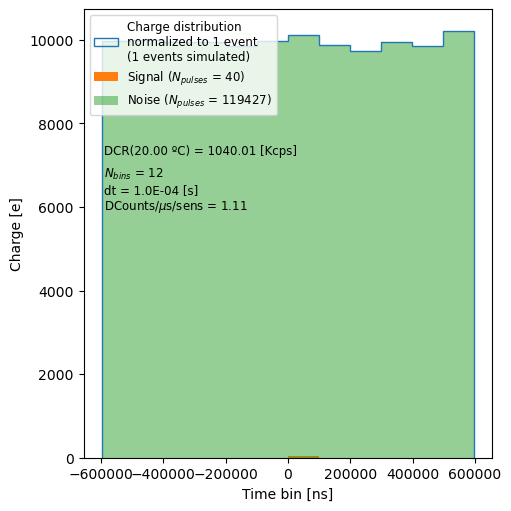

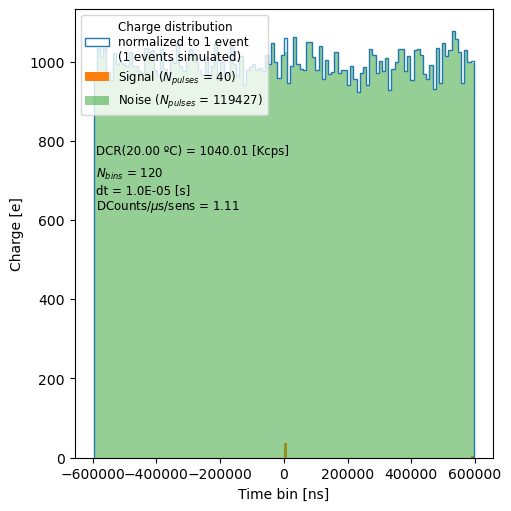

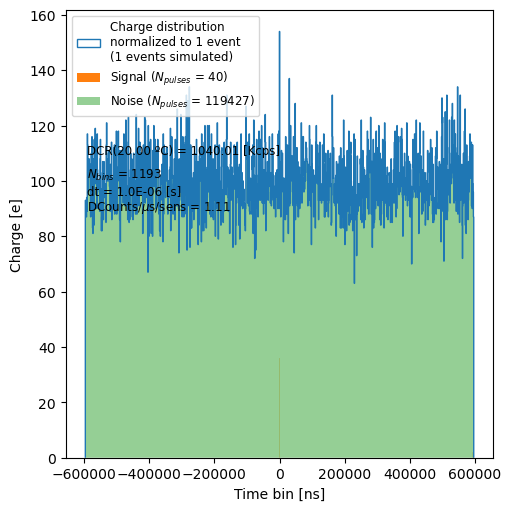

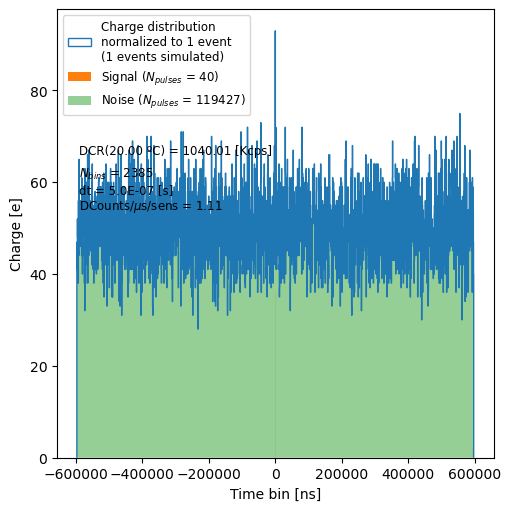

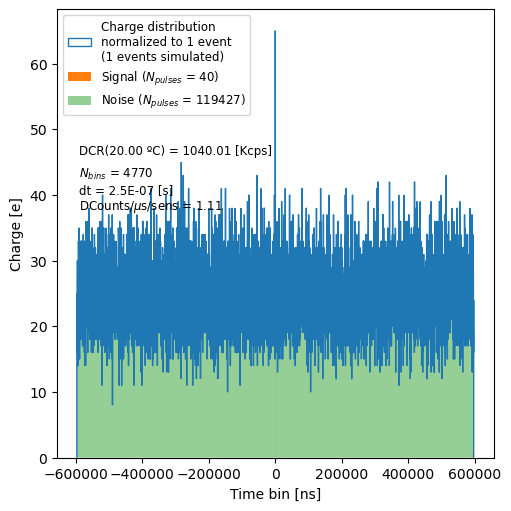

In [54]:
for temp in [25, 22.5, 20]:
    
    DCR = dark_rate(dark25, dT, temp)

    n_1pe, n_2pe = noise(DCR, x_talk, t0, tf, dt, n_sensors)

    print('We have %s 1pe dark pulses and %s 2pe dark pulses'%(n_1pe, n_2pe))

    noise_1pe = np.random.randint(t0*1e9, tf*1e9, n_1pe) # [ns]
    noise_2pe = np.random.randint(t0*1e9, tf*1e9, n_2pe) # [ns]

    t_noise = np.concatenate((noise_1pe, noise_2pe))
    c_noise = np.concatenate((1*np.ones(n_1pe), 2*np.ones(n_2pe)))

    t_signal = np.asarray(dst.time_bin)
    c_signal = np.asarray(dst.charge)

    tt = np.concatenate((t_signal, t_noise))
    cc = np.concatenate((c_signal/n_events, c_noise))


    font_size = 8.5

    # for n_bins in [200, 150, 100, 70, 50, 20, 10, 5]:
    for dt in [1e-4, 1e-5, 1e-6, 0.5e-6, 0.25e-6]:

        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

        t_low = -1*(tt.max())
        t_up = tt.max()

    #     dt = (t_up - t_low)*1e-9/n_bins # [s]
        n_bins = int((t_up - t_low)*1e-9/dt) + 1

        # "Data"
        events, bins, bars = ax.hist(tt, n_bins, 
                                     weights = cc,  # only part of it has to be normalized (signal part)
                                     density=False,
                                     range=(t_low, t_up),
                                     label='Charge distribution \nnormalized to 1 event \n(%i events simulated)'%(n_events), 
                                     histtype='step')


        # Signal
        s_events, s_bins, s_bars = ax.hist(t_signal, n_bins, 
                                           weights = c_signal/n_events,
                                           density=False,
                                           range=(t_low, t_up),
                                           label='Signal ($N_{pulses}$ = %i)'%((c_signal/n_events).sum()), 
                                           alpha = 1,
                                           histtype='stepfilled')


        # Noise
        bkg_events, bkg_bins, bkg_bars = ax.hist(t_noise, n_bins, 
                                                 weights = c_noise, # noise is already normalized
                                                 density=False,
                                                 range=(t_low, t_up),
                                                 label='Noise ($N_{pulses}$ = %i)'%(c_noise.sum()), 
                                                 alpha = 0.5,
                                                 histtype='stepfilled')


        ax.text(0.05, .7, 
                'DCR(%.2f ºC) = %.2f [Kcps]'%(temp, DCR), 
                transform = ax.transAxes,
                fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
                bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))


        ax.text(0.05, .65, 
                '$N_{bins}$ = %s \ndt = %.1E [s] \nDCounts/$\mu$s/sens = %.2f'%(n_bins, dt, bkg_events.mean()*1e-6/dt/n_sensors), 
                transform = ax.transAxes,
                fontsize = font_size, verticalalignment = 'top', #fontfamily = 'serif',
                bbox = dict(facecolor='1.', edgecolor = 'none', pad = 1., alpha = 0.))

        ax.set_ylabel('Charge [e]')
        ax.set_xlabel('Time bin [ns]')
        ax.legend(fontsize = font_size, loc = 'upper left');

        print('Total events = %i = %i (signal) + %i (bkg) = %i'%(s_events.sum() + bkg_events.sum(), 
                                                                 s_events.sum(), bkg_events.sum(), 
                                                                 events.sum()))

